In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# --- SETTINGS ---
base_dir = Path("dataset_clean_validation")  # adjust if needed

# --- COLLECT DATA ---
records = []
for file in base_dir.rglob("*_missing.csv"):
    try:
        df = pd.read_csv(file)
    except Exception as e:
        print(f"Skipping {file}: {e}")
        continue
    
    if "n_total" not in df.columns or "n_nans" not in df.columns:
        continue  # skip irrelevant files

    # Compute availability
    n_total = df.loc[0, "n_total"]
    n_nans = df.loc[0, "n_nans"]
    availability = 1 - n_nans / n_total if n_total > 0 else 0

    # Parse machine, measurement, year from path
    # Example: validation_results\EPI_ChipPress\Freq\2018_Freq_missing.csv
    try:
        machine = file.parts[1]      # e.g. "EPI_ChipPress"
        measurement = file.parts[2]  # e.g. "Freq"
        year = int(file.stem.split("_")[0])  # e.g. "2018"
    except Exception:
        continue

    records.append([machine, measurement, year, availability])

df_all = pd.DataFrame(records, columns=["machine", "measurement", "year", "availability"])

# # --- PLOT: Lollipop Chart ---
# machines = sorted(df_all["machine"].unique())

# fig, ax = plt.subplots(figsize=(10, len(machines) * 0.35))

# for i, m in enumerate(machines):
#     subset = df_all[df_all["machine"] == m].sort_values("year")
#     ax.plot(subset["availability"]*100, [i]*len(subset), "o-", alpha=0.8)

# ax.set_yticks(range(len(machines)))
# ax.set_yticklabels(machines)
# ax.set_xlabel("Availability (%)")
# ax.set_title("Machine-wise Data Availability per Year")

# ax.set_xlim(0, 105)
# ax.grid(axis="x", linestyle="--", alpha=0.6)

# plt.tight_layout()
# plt.show()

In [13]:
df_all

,machine,measurement,year,availability
0,EPI_ChipPress,Freq,2018,0.894253
1,EPI_ChipPress,Freq,2019,0.680976
2,EPI_ChipPress,Freq,2020,0.711715
3,EPI_ChipPress,Freq,2021,0.720484
4,EPI_ChipPress,Freq,2022,0.793986
...,...,...,...,...
15350,TEC_MV2400R,U3_h5,2024,0.906009
15351,TEC_MV2400R,U_line_avg,2024,0.951372
15352,TEC_MV2400R,U_line_avg_f,2024,0.905821
15353,TEC_MV2400R,U_phase_avg,2024,0.951371


In [ ]:
#df_all.to_csv("dataset_clean/00meta_data/02data_availability.csv")

In [5]:
from pathlib import Path

# Where to save (Windows-friendly, works cross-platform with Path)
meta_dir = Path("dataset_clean") / "00meta_data"
meta_dir.mkdir(parents=True, exist_ok=True)

out_path = meta_dir / "data_availability.csv"   # or .parquet if you prefer
# sanity columns (if you want)
required = {"machine","measurement","year","availability"}
missing = required - set(df_all.columns)
assert not missing, f"df_all missing columns: {missing}"

# save
df_all.to_csv(out_path, index=False)
print(f"Saved: {out_path.resolve()}")


Saved: D:\EnergyDataset\dataset_clean\00meta_data\data_availability.csv


In [11]:
# -*- coding: utf-8 -*-
# Filter data_availability by removing meaningless files listed in:
# dataset_clean/00meta_data/01removed_files_registry.csv

import pandas as pd
from pathlib import Path
from datetime import datetime

# ---------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------
meta_dir = Path("dataset_clean") / "00meta_data"
avail_path = meta_dir / "data_availability.csv"
removed_path = meta_dir / "01removed_files_registry.csv"

# Outputs
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_path_ts = meta_dir / f"data_availability.backup_{timestamp}.csv"
backup_path_plain = meta_dir / "data_availability.original.csv"
filtered_csv = meta_dir / "data_availability.filtered.csv"
filtered_parquet = meta_dir / "data_availability.filtered.parquet"

# ---------------------------------------------------------------------
# Load source files
# ---------------------------------------------------------------------
df = pd.read_csv(avail_path)
removed = pd.read_csv(removed_path)

# Basic sanity checks / typing
for c in ["machine", "measurement", "year", "availability"]:
    if c not in df.columns:
        raise ValueError(f"data_availability is missing required column: {c}")

for c in ["machine", "measurement", "year"]:
    if c not in removed.columns:
        raise ValueError(f"removed_files_registry is missing required column: {c}")

# Normalize types & whitespace/case
df["machine"] = df["machine"].astype(str).str.strip()
df["measurement"] = df["measurement"].astype(str).str.strip()
df["year"] = df["year"].astype(int)

removed["machine"] = removed["machine"].astype(str).str.strip()
removed["measurement"] = removed["measurement"].astype(str).str.strip()
removed["year"] = removed["year"].astype(int)

# ---------------------------------------------------------------------
# Backup the original availability file
# ---------------------------------------------------------------------
df.to_csv(backup_path_ts, index=False)
# Also keep a stable-named backup (overwrites on re-run)
df.to_csv(backup_path_plain, index=False)
print(f"[backup] Saved backups:\n - {backup_path_ts}\n - {backup_path_plain}")

# ---------------------------------------------------------------------
# Exclude meaningless files (anti-join on machine,measurement,year)
# ---------------------------------------------------------------------
# deduplicate removed triplets just in case
removed_keys = removed[["machine", "measurement", "year"]].drop_duplicates()

before_n = len(df)
df_filtered = (
    df.merge(removed_keys.assign(_drop=1), on=["machine", "measurement", "year"], how="left")
      .loc[lambda x: x["_drop"].isna()]              # keep rows NOT found in removed list
      .drop(columns=["_drop"])
      .reset_index(drop=True)
)
after_n = len(df_filtered)
removed_n = before_n - after_n

# ---------------------------------------------------------------------
# Save adjusted/filtered availability
# ---------------------------------------------------------------------
df_filtered.to_csv(filtered_csv, index=False)
try:
    df_filtered.to_parquet(filtered_parquet, index=False)
    wrote_parquet = True
except Exception as e:
    wrote_parquet = False
    print(f"[warn] Could not write parquet: {e}")

print(
    f"[done] Filtered availability saved:\n"
    f" - CSV: {filtered_csv}\n"
    f"{' - Parquet: ' + str(filtered_parquet) if wrote_parquet else ''}\n"
    f"[summary] rows before: {before_n:,} | removed by registry: {removed_n:,} | after: {after_n:,}"
)

# Optional: sanity check — show any registry entries that were NOT present in df
# (helpful to catch mismatches in names/years)
missing_from_df = (
    removed_keys.merge(df[["machine", "measurement", "year"]].drop_duplicates(),
                       on=["machine", "measurement", "year"], how="left", indicator=True)
                 .query("_merge == 'left_only'")
                 .drop(columns=["_merge"])
)
if not missing_from_df.empty:
    print(f"[note] {len(missing_from_df)} registry triplets not found in data_availability. Example(s):")
    print(missing_from_df.head(10).to_string(index=False))


[backup] Saved backups:
 - dataset_clean\00meta_data\data_availability.backup_20250819_104506.csv
 - dataset_clean\00meta_data\data_availability.original.csv
[done] Filtered availability saved:
 - CSV: dataset_clean\00meta_data\data_availability.filtered.csv
 - Parquet: dataset_clean\00meta_data\data_availability.filtered.parquet
[summary] rows before: 14,650 | removed by registry: 1,352 | after: 13,298


[saved] 01Figures/Fig_Availability.pdf


(<Figure size 1550x1196 with 2 Axes>,
 (<Axes: xlabel='Availability (%)', ylabel='Machines (sorted by median availability)'>,
  <Axes: xlabel='Share of missing seconds (%)'>))

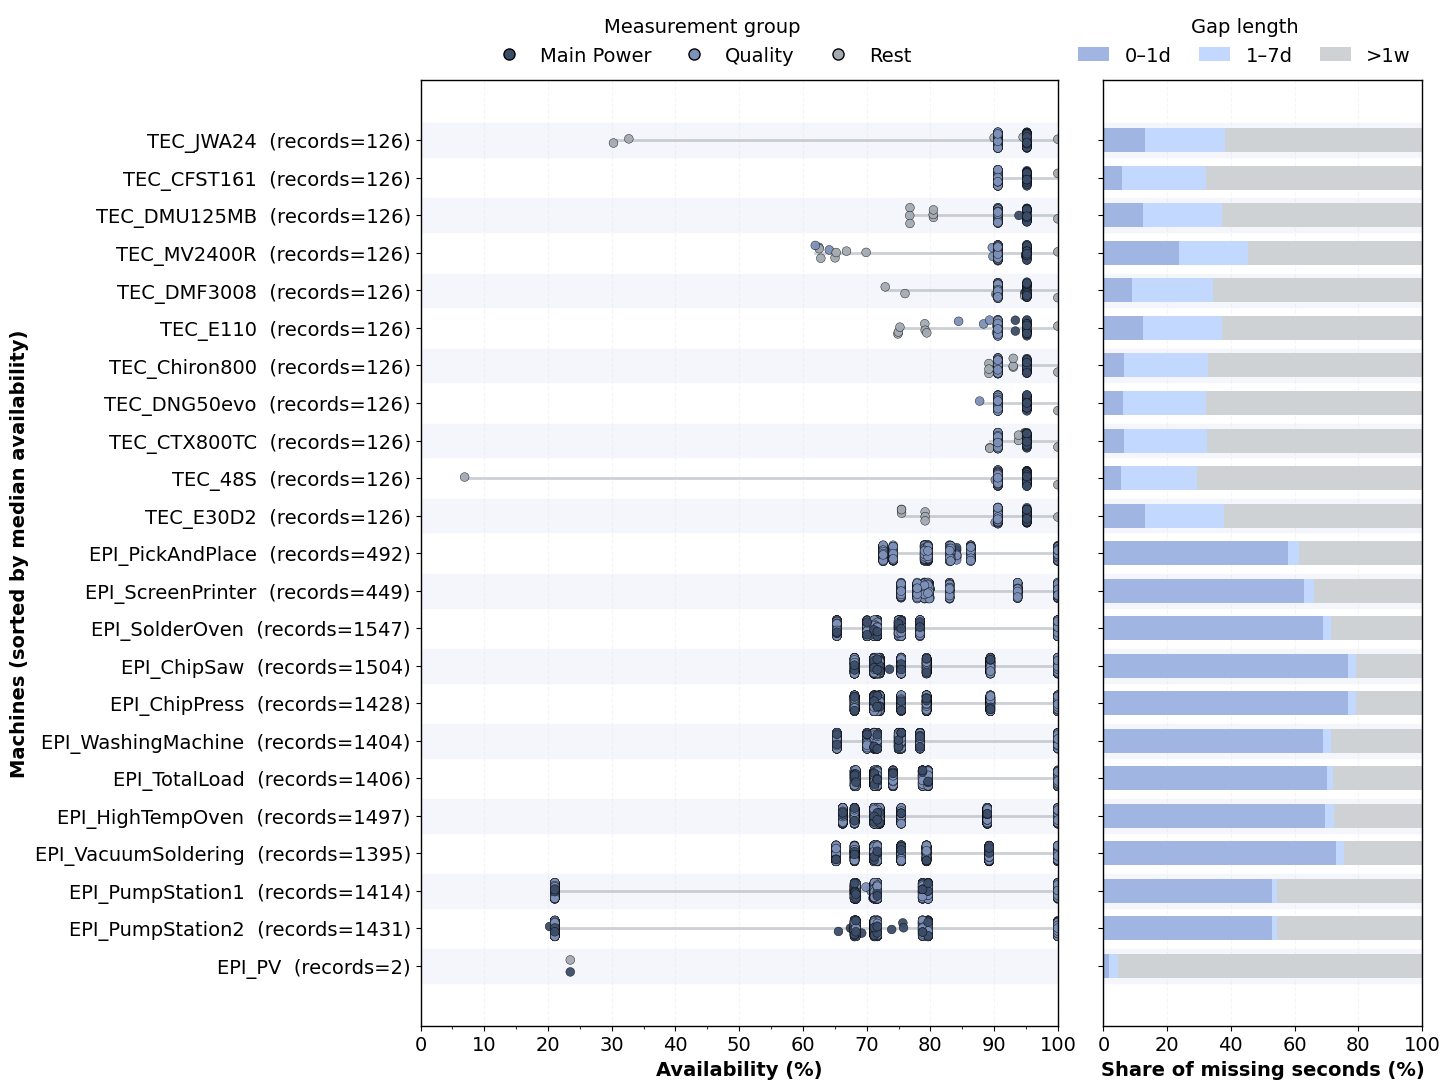

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from pathlib import Path
import hashlib
import re

# Your palette
PALETTE = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2",
           "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]

def plot_availability_and_gaps(
    meta_dir: str | Path = "dataset_clean/00meta_data",
    availability_csv: str = "02data_availability.csv",
    gap_csv: str = "03gap_composition_by_machine.csv",
    save: str | None = "Fig_Availability.pdf",
):
    """Availability (left, 2/3) + Gap-length composition (right, 1/3)."""

    mpl.rcParams.update({
        "font.size": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "axes.linewidth": 1.0,
    })

    META = Path(meta_dir)

    # ----------------------------- LOAD (availability) -------------------
    avail_path = META / availability_csv
    df_all = pd.read_csv(avail_path)
    df_all["year"] = df_all["year"].astype(int)
    df_all["availability"] = df_all["availability"].astype(float)
    df_all["measurement"] = df_all["measurement"].astype(str)
    df_all["machine"] = df_all["machine"].astype(str)

    # --------------------------- GROUPING --------------------------------
    _main_kw  = ["volt","u","v","curr","i","power","p","q","s","pf","freq","gridfreq",
                 "dc_voltage","dc_current","dc_power","ac_activepower"]
    _quality_kw = ["thd","harm","_h","fund","_f"]
    _main_pat = re.compile("|".join(_main_kw), flags=re.IGNORECASE)
    _qual_pat = re.compile("|".join(_quality_kw), flags=re.IGNORECASE)

    def assign_group(measurement: str) -> str:
        m = measurement.lower()
        if any(k in m for k in ["yield","energy","angle","cos_phi","rotfield","loadtype","systemtime","ophours"]):
            return "Rest"
        if _qual_pat.search(m): return "Quality"
        if _main_pat.search(m): return "Main Power"
        return "Rest"

    df_all["group"] = df_all["measurement"].apply(assign_group)

    # ----------------------- ORDERING + COUNTS ---------------------------
    order = (df_all.groupby("machine")["availability"]
             .median().sort_values(ascending=True).index.tolist())
    files_per_machine = df_all.groupby("machine").size().reindex(order)

    # -------------------------- JITTER -----------------------------------
    def stable_jitter(machine: str, measurement: str, year: int, width: float = 0.22) -> float:
        key = f"{machine}|{measurement}|{year}"
        h = hashlib.sha1(key.encode("utf-8")).hexdigest()
        u = int(h[:8], 16) / 16**8
        return (u - 0.5) * 2 * width

    row_index = {m: i for i, m in enumerate(order)}
    df_all["y"] = [row_index[m] + stable_jitter(m, meas, int(y))
                   for m, meas, y in zip(df_all["machine"], df_all["measurement"], df_all["year"])]

    # --------------------------- COLORS (palette) -------------------------
    # Use distinct tones from your palette
    meas_colors = {
        "Main Power": PALETTE[0],  # dark blue
        "Quality":    PALETTE[2],  # mid blue
        "Rest":       PALETTE[6],  # gray-blue
    }
    # Gap-length bins (lighter tones from palette)
    gap_colors = {
        "0–1d": PALETTE[3],
        "1–7d": PALETTE[4],
        ">1w":  PALETTE[7],
    }

    # ------------------------ LOAD GAP COMPOSITION -----------------------
    gap_path = META / gap_csv
    df_gap = pd.read_csv(gap_path)

    # Accept either 4-bin or already collapsed CSV
    if {"<60min","1h–1d","1d–1w",">1w"}.issubset(df_gap.columns):
        df_gap["0–1d"] = df_gap["<60min"].fillna(0) + df_gap["1h–1d"].fillna(0)
        df_gap["1–7d"] = df_gap["1d–1w"].fillna(0)
        df_gap[">1w"]  = df_gap[">1w"].fillna(0)
    elif {"0–1d","1–7d",">1w"}.issubset(df_gap.columns):
        pass
    else:
        raise RuntimeError("gap_composition_by_machine.csv is missing expected columns.")

    df_len = (df_gap[["machine","0–1d","1–7d",">1w"]]
              .set_index("machine").reindex(order).fillna(0.0))

    # ---------------------------- PLOT (two panels) ----------------------
    fig_height = max(6, 0.52 * len(order))  # tall enough for labels
    fig, (axL, axR) = plt.subplots(
        ncols=2, sharey=True,
        figsize=(15.5, fig_height),
        gridspec_kw={"width_ratios":[2, 1]}   # left = 2/3, right = 1/3
    )

    y_positions = np.arange(len(order))

    # alternating row bands on both axes
    for i in range(len(order)):
        if i % 2 == 0:
            for ax in (axL, axR):
                ax.axhspan(i-0.45, i+0.45, color="#f4f6fb", zorder=0)

    # -------- Left (2/3): Availability (jittered) ------------------------
    # connector lines per machine
    for i, m in enumerate(order):
        sub = df_all[df_all["machine"] == m]
        if sub.empty:
            continue
        x_min = (sub["availability"].min() * 100)
        x_max = (sub["availability"].max() * 100)
        axL.plot([x_min, x_max], [i, i], color=PALETTE[6], lw=2.0, alpha=0.55, zorder=1)

    # jittered points
    axL.scatter(
        df_all["availability"] * 100,
        df_all["y"],
        c=df_all["group"].map(meas_colors),
        s=40, linewidths=0.3, edgecolors="black", alpha=0.95, zorder=2
    )

    # Left axis cosmetics
    axL.set_xlim(0, 100)
    axL.xaxis.set_major_locator(mticker.MultipleLocator(10))
    axL.xaxis.set_minor_locator(mticker.MultipleLocator(5))
    axL.grid(axis="x", which="major", linestyle="--", color=PALETTE[7], alpha=0.22)
    axL.set_xlabel("Availability (%)")

    # y ticks & labels shown on the left
    yticklabels = [f"{m}  (records={int(files_per_machine[m])})" for m in order]
    axL.set_yticks(y_positions)
    axL.set_yticklabels(yticklabels)
    axL.set_ylabel("Machines (sorted by median availability)")

    # Hide y ticklabels on the right only (shared axis)
    axR.tick_params(labelleft=False)

    # -------- Right (1/3): Gap-length composition (stacked bars) --------
    left_stack = np.zeros(len(order))
    for col in ["0–1d","1–7d",">1w"]:
        axR.barh(y_positions, df_len[col].values, left=left_stack, height=0.64,
                 color=gap_colors[col], edgecolor="none", zorder=2)
        left_stack += df_len[col].values

    axR.set_xlim(0, 100)
    axR.xaxis.set_major_locator(mticker.MultipleLocator(20))
    axR.grid(axis="x", linestyle="--", color=PALETTE[7], alpha=0.22)
    axR.set_xlabel("Share of missing seconds (%)")

    # --- Two legends aligned with their columns (with titles) ---
    meas_handles = [mlines.Line2D([0],[0], marker="o", linestyle="", markersize=8,
                                  markerfacecolor=meas_colors[g], markeredgecolor="black", label=g)
                    for g in ["Main Power", "Quality", "Rest"]]
    gap_handles  = [Patch(facecolor=gap_colors[k], edgecolor="none", label=k)
                    for k in ["0–1d","1–7d",">1w"]]

    fig.legend(handles=meas_handles, title="Measurement group",
               loc="upper center",
               bbox_to_anchor=(0.5, 0.95),
               ncol=3, frameon=False, columnspacing=1.4, handlelength=1.6)

    fig.legend(handles=gap_handles, title="Gap length",
               loc="upper center",
               bbox_to_anchor=(0.85, 0.95),
               ncol=3, frameon=False, columnspacing=1.4, handlelength=1.6)

    # Layout — add extra left margin for long machine names, room for legend
    plt.tight_layout(rect=[0.04, 0.03, 0.99, 0.90])

    if save:
        plt.savefig(save, bbox_inches="tight")
        print(f"[saved] {save}")
    return fig, (axL, axR)

plot_availability_and_gaps(
    meta_dir="dataset_clean/00meta_data",
    save="01Figures/Fig_Availability.pdf"
)


[saved] 01Figures/Fig6_availability.pdf


(<Figure size 1550x1196 with 2 Axes>,
 (<Axes: xlabel='Availability (%)', ylabel='Machine (records)'>,
  <Axes: xlabel='Share of missing seconds (%)'>))

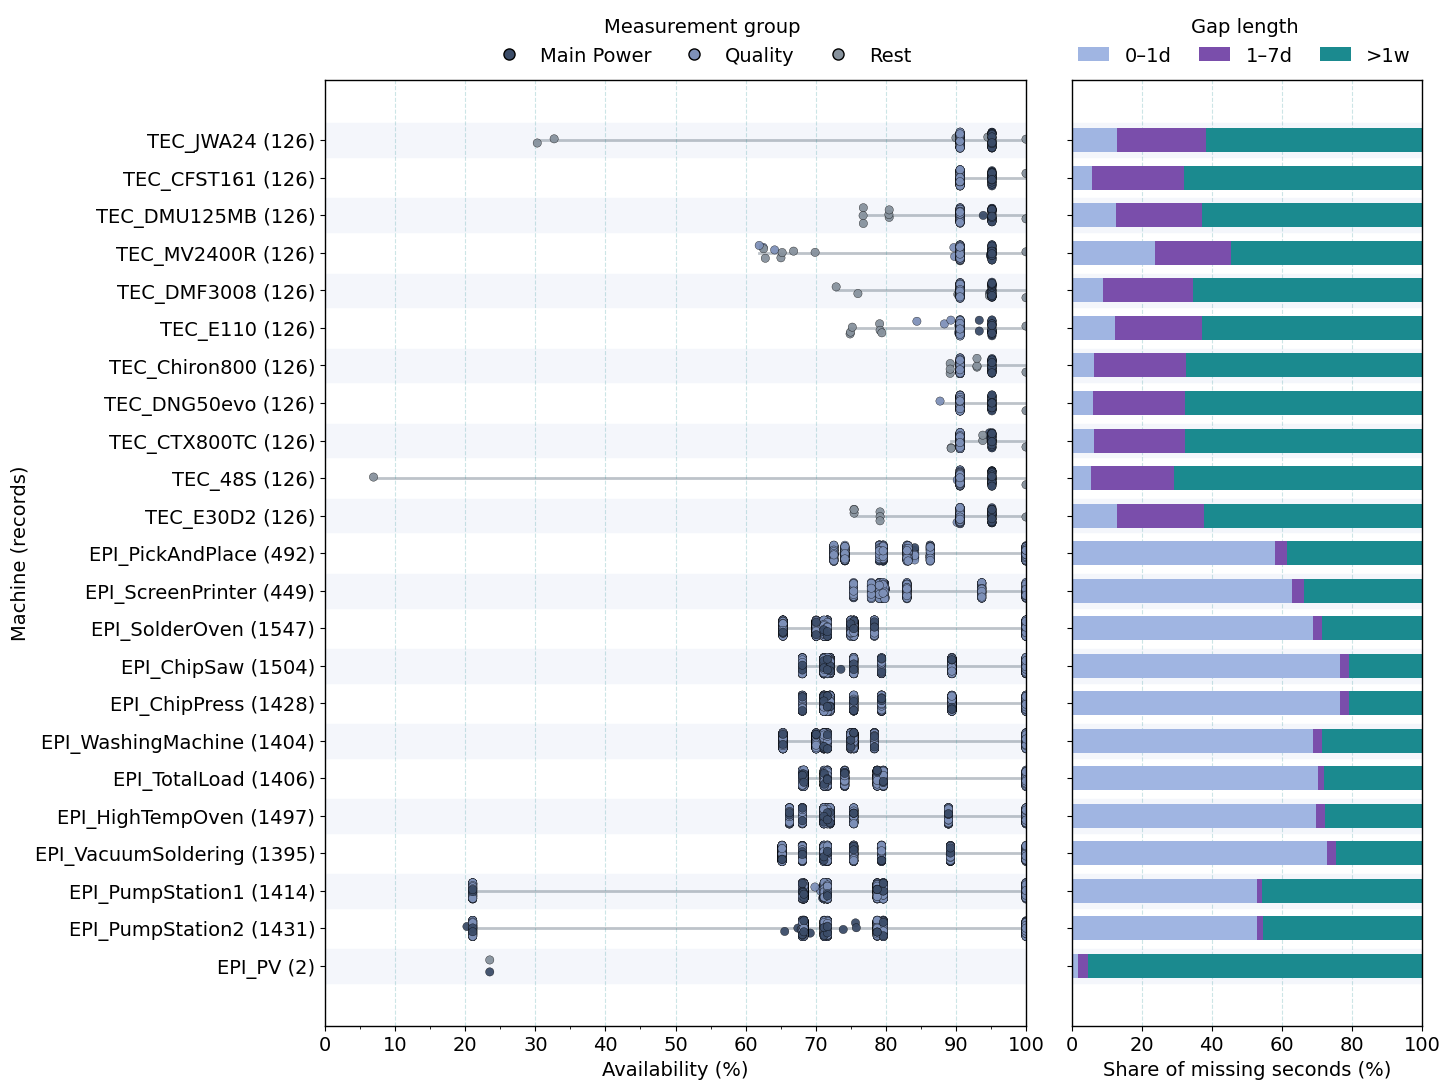

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from pathlib import Path
import hashlib
import re

#PALETTE = ["#1B8A8F", "#3b4c68", "#7A4EAB",  "#a0b5e2", "#D55E00", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]

# Palette
PALETTE = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2",
           "#7A4EAB", "#D55E00", "#87929d", "#1B8A8F"]

def plot_availability_and_gaps(
    meta_dir: str | Path = "dataset_clean/00meta_data",
    availability_csv: str = "02data_availability.csv",
    gap_csv: str = "03gap_composition_by_machine.csv",
    save: str | None = "01Figures/Fig_Availability.pdf",
):
    """Availability (left, 2/3) + Gap-length composition (right, 1/3)."""

    mpl.rcParams.update({
        "font.size": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "axes.linewidth": 1.0,
        # Keep PDFs lighter/simpler
        "path.simplify": True,
        "path.simplify_threshold": 0.2,
        "pdf.fonttype": 42,   # TrueType
        "ps.fonttype": 42,
    })

    META = Path(meta_dir)

    # ----------------------------- LOAD (availability) -------------------
    avail_path = META / availability_csv
    df_all = pd.read_csv(avail_path)
    df_all["year"] = df_all["year"].astype(int)
    df_all["availability"] = df_all["availability"].astype(float)
    df_all["measurement"] = df_all["measurement"].astype(str)
    df_all["machine"] = df_all["machine"].astype(str)

    # --------------------------- GROUPING --------------------------------
    _main_kw  = ["volt","u","v","curr","i","power","p","q","s","pf","freq","gridfreq",
                 "dc_voltage","dc_current","dc_power","ac_activepower"]
    _quality_kw = ["thd","harm","_h","fund","_f"]
    _main_pat = re.compile("|".join(_main_kw), flags=re.IGNORECASE)
    _qual_pat = re.compile("|".join(_quality_kw), flags=re.IGNORECASE)

    def assign_group(measurement: str) -> str:
        m = measurement.lower()
        if any(k in m for k in ["yield","energy","angle","cos_phi","rotfield","loadtype","systemtime","ophours"]):
            return "Rest"
        if _qual_pat.search(m): return "Quality"
        if _main_pat.search(m): return "Main Power"
        return "Rest"

    df_all["group"] = df_all["measurement"].apply(assign_group)

    # ----------------------- ORDERING + COUNTS ---------------------------
    order = (df_all.groupby("machine")["availability"]
             .median().sort_values(ascending=True).index.tolist())
    files_per_machine = df_all.groupby("machine").size().reindex(order)

    # -------------------------- JITTER -----------------------------------
    def stable_jitter(machine: str, measurement: str, year: int, width: float = 0.22) -> float:
        key = f"{machine}|{measurement}|{year}"
        u = int(hashlib.sha1(key.encode("utf-8")).hexdigest()[:8], 16) / 16**8
        return (u - 0.5) * 2 * width

    row_index = {m: i for i, m in enumerate(order)}
    df_all["y"] = [row_index[m] + stable_jitter(m, meas, int(y))
                   for m, meas, y in zip(df_all["machine"], df_all["measurement"], df_all["year"])]

    # --------------------------- COLORS (palette) -------------------------
    meas_colors = {
        "Main Power": PALETTE[0],  # dark blue
        "Quality":    PALETTE[2],  # mid blue
        "Rest":       PALETTE[6],  # gray-blue
    }
    gap_colors = {
        "0–1d": PALETTE[3],
        "1–7d": PALETTE[4],
        ">1w":  PALETTE[7],
    }

    # ------------------------ LOAD GAP COMPOSITION -----------------------
    gap_path = META / gap_csv
    df_gap = pd.read_csv(gap_path)

    if {"<60min","1h–1d","1d–1w",">1w"}.issubset(df_gap.columns):
        df_gap["0–1d"] = df_gap["<60min"].fillna(0) + df_gap["1h–1d"].fillna(0)
        df_gap["1–7d"] = df_gap["1d–1w"].fillna(0)
        df_gap[">1w"]  = df_gap[">1w"].fillna(0)
    elif {"0–1d","1–7d",">1w"}.issubset(df_gap.columns):
        pass
    else:
        raise RuntimeError("gap_composition_by_machine.csv is missing expected columns.")

    df_len = (df_gap[["machine","0–1d","1–7d",">1w"]]
              .set_index("machine").reindex(order).fillna(0.0))

    # ---------------------------- PLOT (two panels) ----------------------
    fig_height = max(6, 0.52 * len(order))
    fig, (axL, axR) = plt.subplots(
        ncols=2, sharey=True,
        figsize=(15.5, fig_height),
        gridspec_kw={"width_ratios":[2, 1]}
    )

    y_positions = np.arange(len(order))

    # alternating row bands
    for i in range(len(order)):
        if i % 2 == 0:
            for ax in (axL, axR):
                ax.axhspan(i-0.45, i+0.45, color="#f4f6fb", zorder=0)

    # -------- Left (2/3): Availability (jittered) ------------------------
    # connector lines per machine
    for i, m in enumerate(order):
        sub = df_all[df_all["machine"] == m]
        if sub.empty:
            continue
        x_min = (sub["availability"].min() * 100)
        x_max = (sub["availability"].max() * 100)
        axL.plot([x_min, x_max], [i, i], color=PALETTE[6], lw=2.0, alpha=0.55, zorder=1, rasterized=True)

    # jittered points (rasterized for lightweight PDF)
    axL.scatter(
        df_all["availability"] * 100,
        df_all["y"],
        c=df_all["group"].map(meas_colors),
        s=36, linewidths=0.25, edgecolors="black", alpha=0.95, zorder=2,
        rasterized=True,
    )

    # Left axis cosmetics
    axL.set_xlim(0, 100)
    axL.xaxis.set_major_locator(mticker.MultipleLocator(10))
    axL.xaxis.set_minor_locator(mticker.MultipleLocator(5))
    axL.grid(axis="x", which="major", linestyle="--", color=PALETTE[7], alpha=0.22)
    axL.set_xlabel("Availability (%)")

    # y ticks & labels (SHORT form: Machine (records))
    yticklabels = [f"{m} ({int(files_per_machine[m])})" for m in order]
    axL.set_yticks(y_positions)
    axL.set_yticklabels(yticklabels)
    axL.set_ylabel("Machine (records)")

    # Hide y ticklabels on the right only (shared axis)
    axR.tick_params(labelleft=False)

    # -------- Right (1/3): Gap-length composition (stacked bars) --------
    left_stack = np.zeros(len(order))
    for col in ["0–1d","1–7d",">1w"]:
        axR.barh(
            y_positions, df_len[col].values, left=left_stack, height=0.64,
            color=gap_colors[col], edgecolor="none", zorder=2, rasterized=True
        )
        left_stack += df_len[col].values

    axR.set_xlim(0, 100)
    axR.xaxis.set_major_locator(mticker.MultipleLocator(20))
    axR.grid(axis="x", linestyle="--", color=PALETTE[7], alpha=0.22)
    axR.set_xlabel("Share of missing seconds (%)")

    # --- Legends (vector; keep crisp) ---
    meas_handles = [mlines.Line2D([0],[0], marker="o", linestyle="", markersize=8,
                                  markerfacecolor=meas_colors[g], markeredgecolor="black", label=g)
                    for g in ["Main Power", "Quality", "Rest"]]
    gap_handles  = [Patch(facecolor=gap_colors[k], edgecolor="none", label=k)
                    for k in ["0–1d","1–7d",">1w"]]

    fig.legend(handles=meas_handles, title="Measurement group",
               loc="upper center",
               bbox_to_anchor=(0.5, 0.95),
               ncol=3, frameon=False, columnspacing=1.4, handlelength=1.6)

    fig.legend(handles=gap_handles, title="Gap length",
               loc="upper center",
               bbox_to_anchor=(0.85, 0.95),
               ncol=3, frameon=False, columnspacing=1.4, handlelength=1.6)

    # Layout — extra margin for long names; leave room for legend
    plt.tight_layout(rect=[0.04, 0.03, 0.99, 0.90])

    if save:
        Path(save).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save, bbox_inches="tight", dpi=200)  # rasterized artists use this dpi
        print(f"[saved] {save}")
    return fig, (axL, axR)


# --- EXECUTION ---
plot_availability_and_gaps(
    meta_dir="dataset_clean/00meta_data",
    save="01Figures/Fig6_availability.pdf"  # consider .png for instant viewing
)


C:\Users\rs1044\AppData\Local\Temp\ipykernel_21012\3278587095.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fc.loc[t] = y_clock.get(key, y_clock.iloc[(np.abs(pd.to_datetime(y_clock.index.astype(str)) - pd.Timestamp.combine(pd.Timestamp.today(), key))).argmin()])
C:\Users\rs1044\AppData\Local\Temp\ipykernel_21012\3278587095.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fc.loc[t] = y_clock.get(key, y_clock.iloc[(np.abs(pd.to_datetime(y_clock.index.astype(str)) - pd.Timestamp.combine(pd.Timestamp.today(), key))).argmin()])
C:\Users\rs1044\AppData\Local\Temp\ipykernel_21012\3278587095.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. T

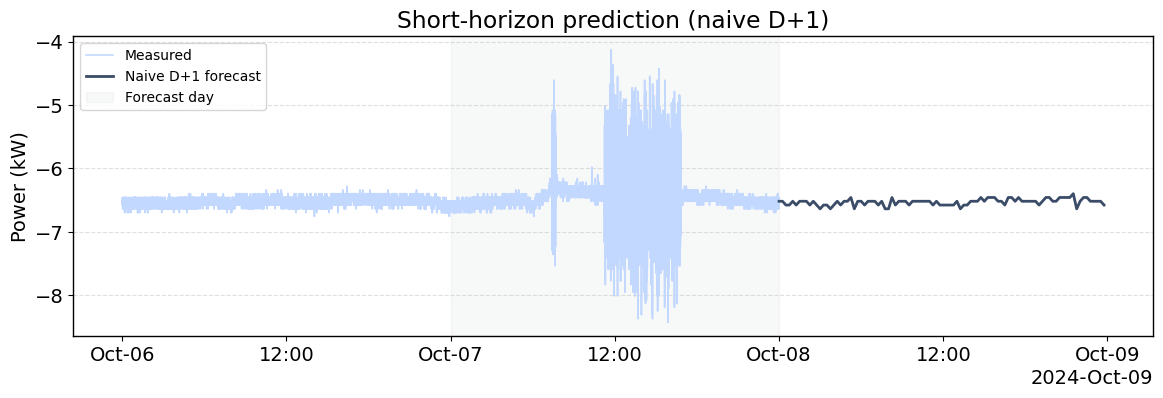

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

PALETTE = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]

# -----------------------------
# 1) PREDICTION (naive D+1)
# -----------------------------
def plot_prediction(machine_power_path, start_date="2022-10-01", days=7, tz="Europe/Berlin", power_col=None):
    df = pd.read_csv(machine_power_path, parse_dates=["WsDateTime"])
    col = power_col or next(c for c in df.columns if c != "WsDateTime")

    if df["WsDateTime"].dt.tz is None:
        df["WsDateTime"] = df["WsDateTime"].dt.tz_localize("UTC")
    t_local = df["WsDateTime"].dt.tz_convert(tz).dt.tz_localize(None)

    P = (df.set_index(t_local)[[col]].rename(columns={col: "P_kW"})
           .sort_index().loc[pd.Timestamp(start_date): pd.Timestamp(start_date)+pd.Timedelta(days=days)])

    if P.empty:
        raise ValueError("No data in selected window.")

    # freq & window edges
    freq = pd.infer_freq(P.index[:8]) or "15min"
    d0 = P.index.min().normalize() + pd.Timedelta(days=days-1)
    d1 = d0 + pd.Timedelta(days=1)

    today = P[(P.index >= d0) & (P.index < d1)]["P_kW"]
    yday  = P[(P.index >= d0 - pd.Timedelta(days=1)) & (P.index < d0)]["P_kW"]

    # Forecast = copy yesterday’s intraday shape
    if not yday.empty:
        y_clock = yday.copy(); y_clock.index = y_clock.index.map(lambda t: t.time())
        forecast_idx = pd.date_range(d1, d1 + (today.index[-1]-today.index[0]), freq=freq)
        fc = pd.Series(index=forecast_idx, dtype=float)
        for t in forecast_idx:
            key = t.time()
            fc.loc[t] = y_clock.get(key, y_clock.iloc[(np.abs(pd.to_datetime(y_clock.index.astype(str)) - pd.Timestamp.combine(pd.Timestamp.today(), key))).argmin()])
    else:
        fc = pd.Series(np.nan, index=pd.date_range(d1, d1 + pd.Timedelta(days=1)-pd.Timedelta(freq), freq=freq))

    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    hist = P[(P.index >= d0 - pd.Timedelta(days=1)) & (P.index < d1)]["P_kW"]
    ax.plot(hist.index, hist.values, color=PALETTE[4], lw=1.2, label="Measured")
    ax.plot(fc.index, fc.values, color=PALETTE[0], lw=2.0, label="Naive D+1 forecast")
    ax.axvspan(d0, d1, color=PALETTE[7], alpha=0.15, label="Forecast day")
    ax.set_title("Short-horizon prediction (naive D+1)")
    ax.set_ylabel("Power (kW)")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.legend(loc="upper left", fontsize=10)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=6))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.15)
    return fig, ax


# -----------------------------
# 2) NILM (toy decomposition)
# -----------------------------
def plot_nilm(machine_power_path, start_date="2022-10-01", days=7, tz="Europe/Berlin", power_col=None):
    df = pd.read_csv(machine_power_path, parse_dates=["WsDateTime"])
    col = power_col or next(c for c in df.columns if c != "WsDateTime")

    if df["WsDateTime"].dt.tz is None:
        df["WsDateTime"] = df["WsDateTime"].dt.tz_localize("UTC")
    t_local = df["WsDateTime"].dt.tz_convert(tz).dt.tz_localize(None)

    P = (df.set_index(t_local)[[col]].rename(columns={col: "P_kW"})
           .sort_index().loc[pd.Timestamp(start_date): pd.Timestamp(start_date)+pd.Timedelta(days=days)])["P_kW"].astype(float)

    if P.empty:
        raise ValueError("No data in selected window.")

    q50, q80, q95 = np.nanpercentile(P.values, [50, 80, 95])
    base = np.minimum(P, q50)
    rem1 = P - base
    dev2 = np.minimum(rem1, max(q80 - q50, 0))
    rem2 = rem1 - dev2
    dev3 = np.minimum(rem2, max(q95 - q80, 0))
    resid = np.clip(P - (base + dev2 + dev3), 0, None)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(P.index, P.values, color="#000000", lw=1.0, alpha=0.7, label="Measured")
    ax.fill_between(P.index, 0, base.values, color=PALETTE[2], alpha=0.85, label="Device A (base)")
    ax.fill_between(P.index, base.values, (base+dev2).values, color=PALETTE[1], alpha=0.85, label="Device B")
    ax.fill_between(P.index, (base+dev2).values, (base+dev2+dev3).values, color=PALETTE[0], alpha=0.85, label="Device C")
    if resid.max() > 0:
        ax.fill_between(P.index, (base+dev2+dev3).values, (base+dev2+dev3+resid).values, color=PALETTE[6], alpha=0.5, label="Residual")
    ax.set_title("NILM (toy percentile decomposition)")
    ax.set_ylabel("Power (kW)")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.legend(ncol=2, fontsize=10, loc="upper left")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=6))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.15)
    return fig, ax


# -----------------------------
# 3) BATTERY optimization (greedy thresholds)
# -----------------------------
def plot_battery_optimization(
    machine_power_path,
    price_path,
    start_date="2022-10-01", days=7, tz="Europe/Berlin",
    power_col=None,
    battery_kwh=500.0, battery_kw=250.0, eta_roundtrip=0.9, soc0=0.5
):
    # Power
    dfP = pd.read_csv(machine_power_path, parse_dates=["WsDateTime"])
    col = power_col or next(c for c in dfP.columns if c != "WsDateTime")
    if dfP["WsDateTime"].dt.tz is None:
        dfP["WsDateTime"] = dfP["WsDateTime"].dt.tz_localize("UTC")
    t_local = dfP["WsDateTime"].dt.tz_convert(tz).dt.tz_localize(None)
    P = (dfP.set_index(t_local)[[col]].rename(columns={col: "P_kW"})
           .sort_index().loc[pd.Timestamp(start_date): pd.Timestamp(start_date)+pd.Timedelta(days=days)])["P_kW"].astype(float)

    if P.empty:
        raise ValueError("No data in selected window.")

    # Price (to local, align to power timestamps)
    price = (pd.read_csv(price_path, parse_dates=["utc_datetime"])
             .set_index("utc_datetime").sort_index())
    if price.index.tz is None:
        price.index = price.index.tz_localize("UTC")
    price.index = price.index.tz_convert(tz).tz_localize(None)
    price = price["price_eur_per_mwh"].reindex(P.index, method="nearest", tolerance=pd.Timedelta("30min")).astype(float)

    # Greedy policy thresholds
    step_h = (P.index[1] - P.index[0]).total_seconds()/3600.0
    soc = np.zeros(len(P)); soc[0] = soc0 * battery_kwh
    charge = np.zeros(len(P)); discharge = np.zeros(len(P))
    win = int(max(1, round(24/step_h)))
    p_lo = price.rolling(win, min_periods=1).median()
    p_hi = price.rolling(win, min_periods=1).quantile(0.8)
    eta_c = np.sqrt(eta_roundtrip); eta_d = np.sqrt(eta_roundtrip)

    for i in range(1, len(P)):
        p = price.iloc[i]
        if p <= p_lo.iloc[i] and soc[i-1] < battery_kwh:
            pwr = min(battery_kw, (battery_kwh - soc[i-1]) / (eta_c*step_h))
            charge[i] = pwr; soc[i] = soc[i-1] + pwr * eta_c * step_h
        elif p >= p_hi.iloc[i] and soc[i-1] > 0:
            pwr = min(battery_kw, soc[i-1] / (eta_d*step_h))
            discharge[i] = pwr; soc[i] = soc[i-1] - pwr * eta_d * step_h
        else:
            soc[i] = soc[i-1]

    P_net = P + charge - discharge

    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(P.index, P.values, color=PALETTE[3], lw=1.2, label="Baseline load")
    ax.plot(P_net.index, P_net.values, color=PALETTE[0], lw=1.8, label="With battery")
    ax.fill_between(P.index, P.values, P_net.values, where=(P_net<P), color="#2ca02c", alpha=0.25, label="Discharge → reduce")
    ax.fill_between(P.index, P.values, P_net.values, where=(P_net>P), color="#d62728", alpha=0.15, label="Charge → increase")
    ax2 = ax.twinx()
    ax2.plot(P.index, soc, color=PALETTE[5], lw=1.5, alpha=0.9, label="SoC (kWh)")

    ax.set_title("Battery optimization (price-based greedy)")
    ax.set_ylabel("Power (kW)"); ax2.set_ylabel("SoC (kWh)")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=6))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines+lines2, labels+labels2, fontsize=10, loc="upper left")
    fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.15)
    return fig, (ax, ax2)

# -----------------------------
# EXAMPLES (uncomment & edit)
# -----------------------------
fig, ax  = plot_prediction(
    machine_power_path=r"dataset_clean/TEC_Chiron800/P1/2024_P1.csv.xz",
    start_date="2024-10-01", days=7, tz="Europe/Berlin"
)
# fig, ax  = plot_nilm(
#     machine_power_path=r"dataset_clean/TEC_Chiron800/P/2022_P.csv.xz",
#     start_date="2022-10-01", days=7, tz="Europe/Berlin"
# )
# fig, axs = plot_battery_optimization(
#     machine_power_path=r"dataset_clean/TEC_Chiron800/P/2022_P.csv.xz",
#     price_path=r"dataset_clean/01exogenous_data/electricity_prices_15min_de_2018_2024.csv",
#     start_date="2022-10-01", days=7, tz="Europe/Berlin",
#     battery_kwh=500, battery_kw=250, eta_roundtrip=0.9, soc0=0.5
# )


In [21]:
import pandas as pd

u1_df = pd.read_csv(r"dataset_clean\TEC_Chiron800\I1\2024_I1.csv.xz")
u2_df = pd.read_csv(r"dataset_clean\TEC_Chiron800\I2\2024_I2.csv.xz")

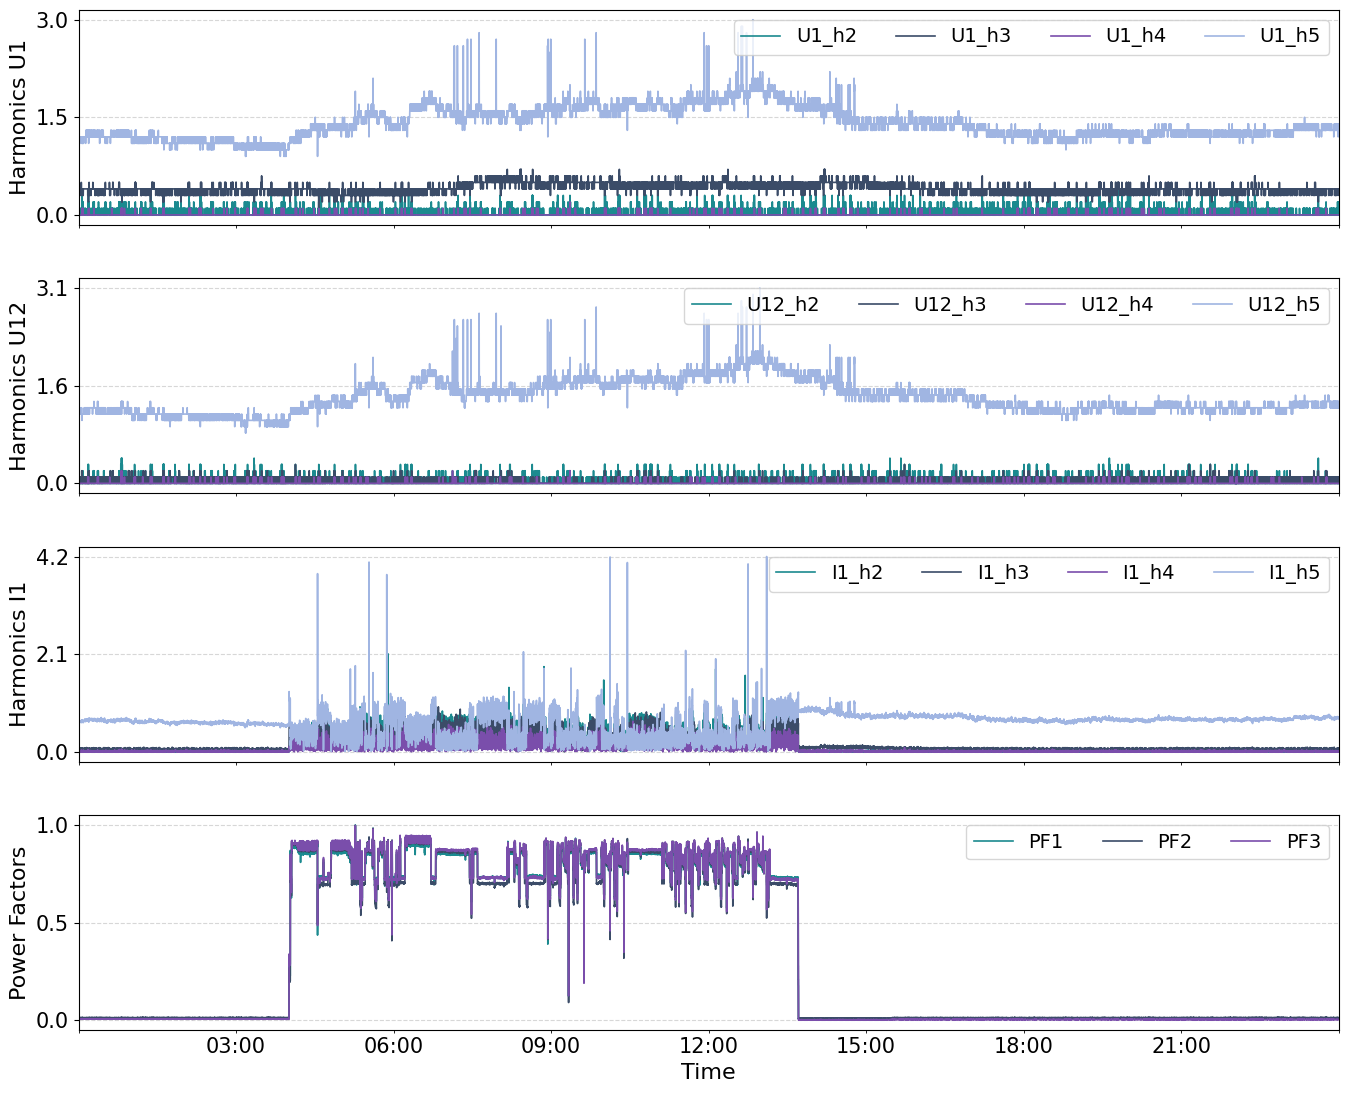

(<Figure size 1400x1200 with 4 Axes>,
 array([<Axes: xlabel='WsDateTime', ylabel='Harmonics U1'>,
        <Axes: xlabel='WsDateTime', ylabel='Harmonics U12'>,
        <Axes: xlabel='WsDateTime', ylabel='Harmonics I1'>,
        <Axes: xlabel='Time', ylabel='Power Factors'>], dtype=object))

In [1]:
# One clean function + execution.
# - Reads per-measurement CSV.XZ files: r"dataset_clean/TEC_Chiron800/<MEASUREMENT>/2024_<MEASUREMENT>.csv.xz"
# - Columns in each file: [WsDateTime, <MEASUREMENT>]
# - Filters EXACTLY the provided day (robust to DST via .dt.date)
# - Leaves gaps for outages (no interpolation)
# - Five ROWS of subplots (each row its own axis):
#     1) Voltages (U1, U2, U3, U_phase_avg)
#     2) Line voltages (U12, U23, U31, U_line_avg)
#     3) Currents (I1, I2, I3, I_sys)
#     4) Apparent power (S1, S2, S3, S_total)
#     5) Frequency (Freq)
# - X-axis ticks fixed at 00:00, 06:00, 12:00, 18:00, 24:00 (first & last guaranteed)
# - Y-axis: labels with exactly 1 decimal; include the data min & max as tick labels; axis limits padded by ±5%
# - Custom color palette for lines.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FuncFormatter

#PALETTE = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]
PALETTE = ["#1B8A8F", "#3b4c68", "#7A4EAB",  "#a0b5e2", "#D55E00", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]

def plot_day_multi(u_root="dataset_clean/TEC_Chiron800", date_str="2024-10-27", save=False):
    """
    Load many measurements for one day and plot them in five stacked subplots.
    Files must be at: {u_root}/<MEASUREMENT>/2024_<MEASUREMENT>.csv.xz with columns [WsDateTime, <MEASUREMENT>].
    """

    # =========================
    # CONFIG (what to plot in each row)
    # =========================
    row1 = ["U1_h2","U1_h3","U1_h4","U1_h5"]
    row2 = ["U12_h2","U12_h3","U12_h4","U12_h5"]
    row3 = ["I1_h2","I1_h3","I1_h4","I1_h5"]
    row4 = ["PF1","PF2","PF3"]

    rows = [row1, row2, row3, row4]
    row_titles = ["Harmonics U1", "Harmonics U12", "Harmonics I1", "Power Factors"]

    # =========================
    # LOAD DATA
    # =========================
    day = pd.to_datetime(date_str).date()

    def load_series(meas):
        path = f"{u_root}/{meas}/2024_{meas}.csv.xz"
        df = pd.read_csv(path, compression="xz", parse_dates=["WsDateTime"])
        val_col = next(c for c in df.columns if c != "WsDateTime")
        sel = df[df["WsDateTime"].dt.date == day]
        return pd.Series(sel[val_col].values, index=sel["WsDateTime"], name=meas)

    row_dfs = []
    for group in rows:
        series_list = [load_series(m) for m in group]
        df = pd.concat(series_list, axis=1)
        df.index = pd.to_datetime(df.index).tz_localize(None)
        row_dfs.append(df)

    # =========================
    # PLOT
    # =========================
    fig, axes = plt.subplots(nrows=len(rows), ncols=1, figsize=(14, 12), sharex=True)

    title_fs, label_fs, tick_fs, legend_fs = 20, 16, 15, 14

    for ax, df, title in zip(axes, row_dfs, row_titles):
        colors = PALETTE[:len(df.columns)]
        df.plot(ax=ax, color=colors, linewidth=1.2)  # one axis per row
        ax.set_ylabel(title, fontsize=label_fs)
        ax.grid(True, which="both", axis="y", linestyle="--", alpha=0.5)
        ax.legend(fontsize=legend_fs, ncol=min(4, len(df.columns)))
        ax.tick_params(axis="both", which="both", labelsize=tick_fs)

        # ---- Y-AXIS FORMAT: include min & max as ticks, 1-decimal labels, ±5% margin ----
        row_min = float(np.nanmin(df.values))
        row_max = float(np.nanmax(df.values))
        span = row_max - row_min if row_max != row_min else max(abs(row_max), 1.0)
        pad = 0.05 * span
        ymin, ymax = row_min - pad, row_max + pad
        ax.set_ylim(ymin, ymax)

        ticks = np.linspace(row_min, row_max, 3)  # includes exact min & max
        ticks = np.round(ticks, 6)                # collapse near-duplicates
        ax.yaxis.set_major_locator(FixedLocator(ticks.tolist()))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}"))

    axes[-1].set_xlabel("Time", fontsize=label_fs)

    # =========================
    # FIXED X-TICKS (00:00, 06:00, 12:00, 18:00, 24:00)
    # =========================
    start = pd.Timestamp(date_str)
    end   = start + pd.Timedelta(days=1)
    tick_times = [start + pd.Timedelta(hours=h) for h in (0,6,12,18,24)]
    tick_nums = [mdates.date2num(t.to_pydatetime()) for t in tick_times]

    for ax in axes:
        ax.set_xlim(start.to_pydatetime(), end.to_pydatetime())
        ax.xaxis.set_major_locator(FixedLocator(tick_nums))
        ax.xaxis.set_major_formatter(FuncFormatter(
            lambda x, pos: "24:00" if abs(x - tick_nums[-1]) < 1e-9
            else ("00:00" if abs(x - tick_nums[0]) < 1e-9
                  else f"{int((pos)*6):02d}:00")
        ))
    fig.subplots_adjust(left=0.08, right=0.98, top=0.93, bottom=0.08, hspace=0.25)

    out = None
    if save:
        out = f"tec_chiron800_quality_{date_str}.pdf"
        fig.savefig(out, dpi=150)

    plt.show()
    return fig, axes

# --- EXECUTION: set root folder and day, then run ---
plot_day_multi(u_root="dataset_clean/TEC_Chiron800", date_str="2024-05-15", save=True)


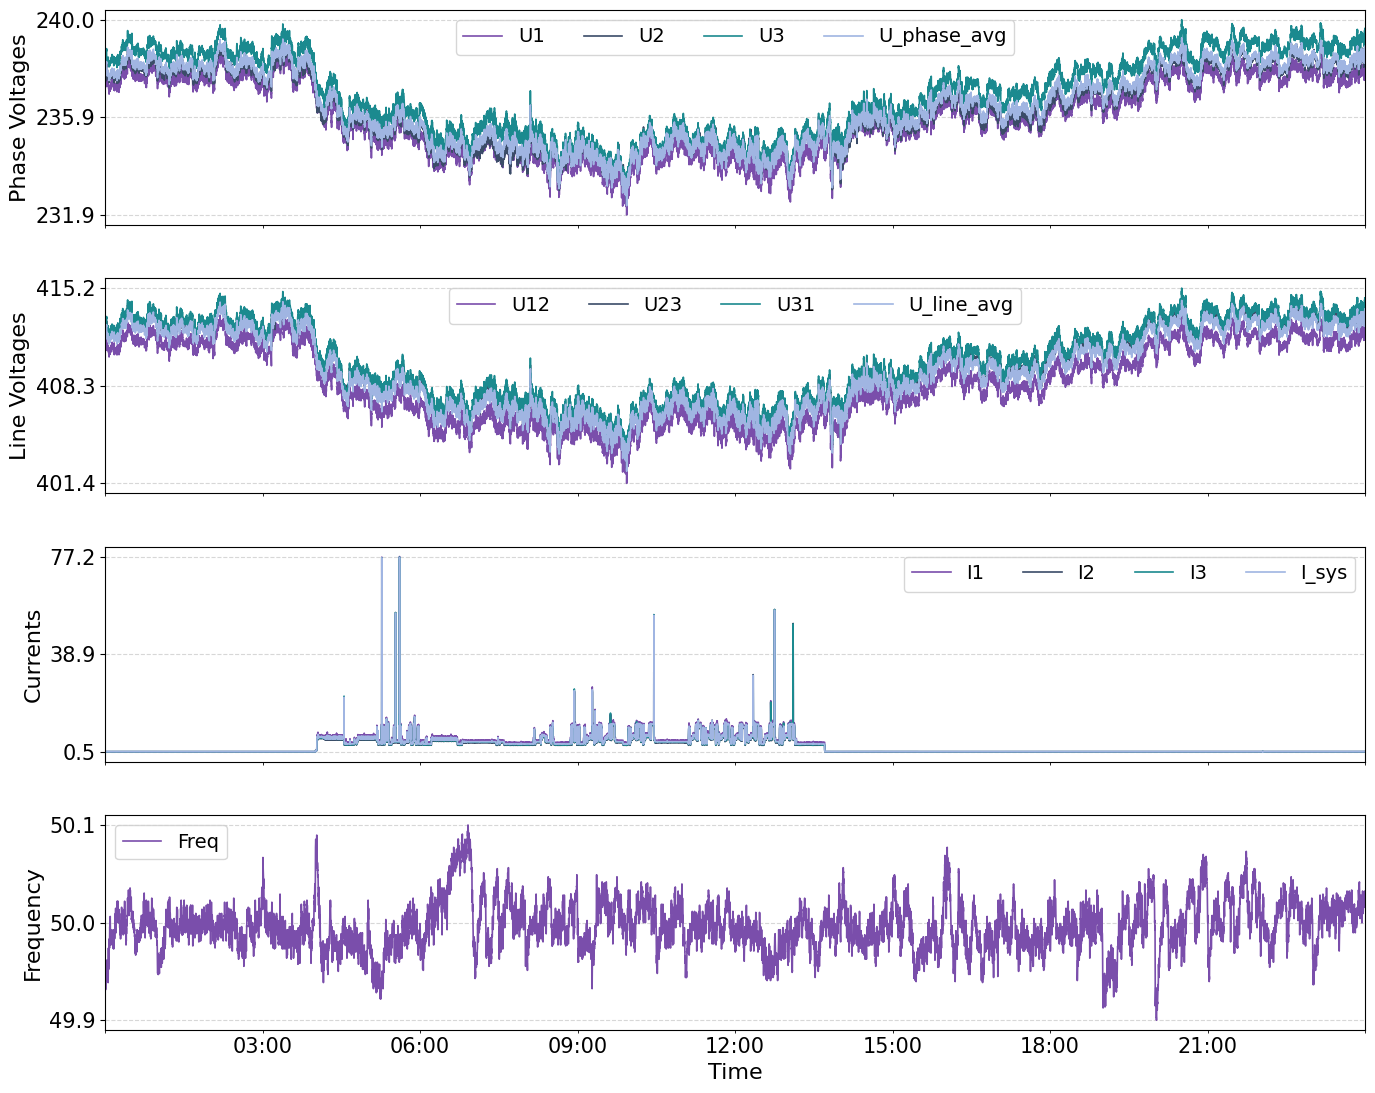

(<Figure size 1400x1200 with 4 Axes>,
 array([<Axes: xlabel='WsDateTime', ylabel='Phase Voltages'>,
        <Axes: xlabel='WsDateTime', ylabel='Line Voltages'>,
        <Axes: xlabel='WsDateTime', ylabel='Currents'>,
        <Axes: xlabel='Time', ylabel='Frequency'>], dtype=object))

In [2]:
# One clean function + execution.
# - Reads per-measurement CSV.XZ files: r"dataset_clean/TEC_Chiron800/<MEASUREMENT>/2024_<MEASUREMENT>.csv.xz"
# - Columns in each file: [WsDateTime, <MEASUREMENT>]
# - Filters EXACTLY the provided day (robust to DST via .dt.date)
# - Leaves gaps for outages (no interpolation)
# - Five ROWS of subplots (each row its own axis):
#     1) Voltages (U1, U2, U3, U_phase_avg)
#     2) Line voltages (U12, U23, U31, U_line_avg)
#     3) Currents (I1, I2, I3, I_sys)
#     4) Apparent power (S1, S2, S3, S_total)
#     5) Frequency (Freq)
# - X-axis ticks fixed at 00:00, 06:00, 12:00, 18:00, 24:00 (first & last guaranteed)
# - Y-axis: labels with exactly 1 decimal; include the data min & max as tick labels; axis limits padded by ±5%
# - Custom color palette for lines.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FuncFormatter

#PALETTE = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]
PALETTE = ["#7A4EAB", "#3b4c68", "#1B8A8F",  "#a0b5e2", "#D55E00", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]

def plot_day_multi(u_root="dataset_clean/TEC_Chiron800", date_str="2024-10-27", save=False):
    """
    Load many measurements for one day and plot them in five stacked subplots.
    Files must be at: {u_root}/<MEASUREMENT>/2024_<MEASUREMENT>.csv.xz with columns [WsDateTime, <MEASUREMENT>].
    """

    # =========================
    # CONFIG (what to plot in each row)
    # =========================
    row1 = ["U1","U2","U3","U_phase_avg"]
    row2 = ["U12","U23","U31","U_line_avg"]
    row3 = ["I1","I2","I3","I_sys"]        # IN
    #row4 = ["THD_I1","THD_I2","THD_I3"]       # ,"S_total"
    row5 = ["Freq"]
    rows = [row1, row2, row3, row5]
    row_titles = ["Phase Voltages", "Line Voltages", "Currents", "Frequency"]

    # =========================
    # LOAD DATA
    # =========================
    day = pd.to_datetime(date_str).date()

    def load_series(meas):
        path = f"{u_root}/{meas}/2024_{meas}.csv.xz"
        df = pd.read_csv(path, compression="xz", parse_dates=["WsDateTime"])
        val_col = next(c for c in df.columns if c != "WsDateTime")
        sel = df[df["WsDateTime"].dt.date == day]
        return pd.Series(sel[val_col].values, index=sel["WsDateTime"], name=meas)

    row_dfs = []
    for group in rows:
        series_list = [load_series(m) for m in group]
        df = pd.concat(series_list, axis=1)
        df.index = pd.to_datetime(df.index).tz_localize(None)
        row_dfs.append(df)

    # =========================
    # PLOT
    # =========================
    fig, axes = plt.subplots(nrows=len(rows), ncols=1, figsize=(14, 12), sharex=True)

    title_fs, label_fs, tick_fs, legend_fs = 20, 16, 15, 14

    for ax, df, title in zip(axes, row_dfs, row_titles):
        colors = PALETTE[:len(df.columns)]
        df.plot(ax=ax, color=colors, linewidth=1.2)  # one axis per row
        ax.set_ylabel(title, fontsize=label_fs)
        ax.grid(True, which="both", axis="y", linestyle="--", alpha=0.5)
        ax.legend(fontsize=legend_fs, ncol=min(4, len(df.columns)))
        ax.tick_params(axis="both", which="both", labelsize=tick_fs)

        # ---- Y-AXIS FORMAT: include min & max as ticks, 1-decimal labels, ±5% margin ----
        row_min = float(np.nanmin(df.values))
        row_max = float(np.nanmax(df.values))
        span = row_max - row_min if row_max != row_min else max(abs(row_max), 1.0)
        pad = 0.05 * span
        ymin, ymax = row_min - pad, row_max + pad
        ax.set_ylim(ymin, ymax)

        ticks = np.linspace(row_min, row_max, 3)  # includes exact min & max
        ticks = np.round(ticks, 6)                # collapse near-duplicates
        ax.yaxis.set_major_locator(FixedLocator(ticks.tolist()))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}"))

    axes[-1].set_xlabel("Time", fontsize=label_fs)

    # =========================
    # FIXED X-TICKS (00:00, 06:00, 12:00, 18:00, 24:00)
    # =========================
    start = pd.Timestamp(date_str)
    end   = start + pd.Timedelta(days=1)
    tick_times = [start + pd.Timedelta(hours=h) for h in (0,6,12,18,24)]
    tick_nums = [mdates.date2num(t.to_pydatetime()) for t in tick_times]

    for ax in axes:
        ax.set_xlim(start.to_pydatetime(), end.to_pydatetime())
        ax.xaxis.set_major_locator(FixedLocator(tick_nums))
        ax.xaxis.set_major_formatter(FuncFormatter(
            lambda x, pos: "24:00" if abs(x - tick_nums[-1]) < 1e-9
            else ("00:00" if abs(x - tick_nums[0]) < 1e-9
                  else f"{int((pos)*6):02d}:00")
        ))
    fig.subplots_adjust(left=0.08, right=0.98, top=0.93, bottom=0.08, hspace=0.25)

    out = None
    if save:
        out = f"tec_chiron800_data_{date_str}.pdf"
        fig.savefig(out, dpi=150)

    plt.show()
    return fig, axes

# --- EXECUTION: set root folder and day, then run ---
plot_day_multi(u_root="dataset_clean/TEC_Chiron800", date_str="2024-05-15", save=True)


C:\Users\rs1044\AppData\Local\Temp\ipykernel_21012\2342079801.py:22: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x = mdates.date2num(sel["WsDateTime"].dt.to_pydatetime())


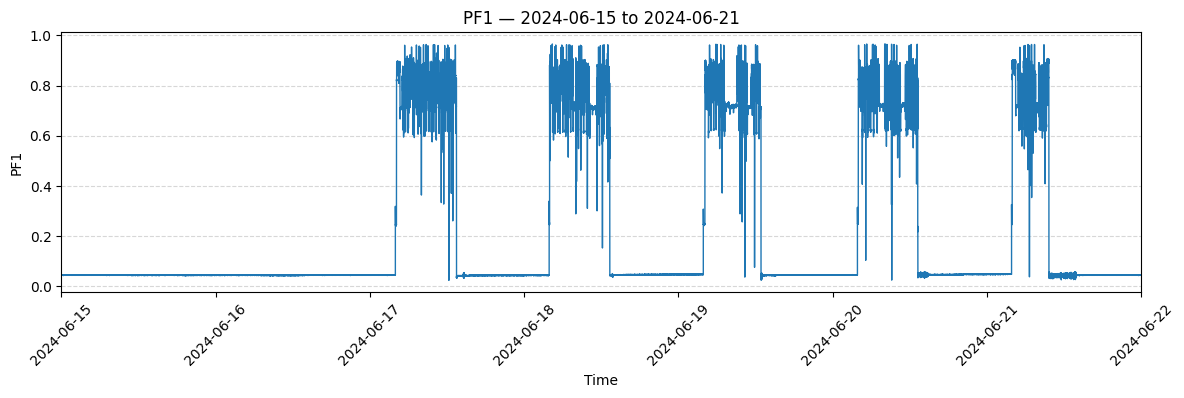

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator

def plot_week_simple(csv_path, start_date_str):
    """
    Plot one week of data starting at (and including) start_date_str.
    CSV.XZ must have columns: 'WsDateTime' and one value column.
    Hardened for many points: fixed x-locator/formatter; no tight_layout.
    """
    df = pd.read_csv(csv_path, compression="xz", parse_dates=["WsDateTime"])
    val_col = next(c for c in df.columns if c != "WsDateTime")

    start = pd.Timestamp(start_date_str)
    end   = start + pd.Timedelta(days=7)

    sel = df[(df["WsDateTime"] >= start) & (df["WsDateTime"] < end)][["WsDateTime", val_col]].copy()
    sel["WsDateTime"] = pd.to_datetime(sel["WsDateTime"]).dt.tz_localize(None)

    # Convert times to Matplotlib's float dates explicitly (avoids overflow with huge arrays)
    x = mdates.date2num(sel["WsDateTime"].dt.to_pydatetime())
    y = sel[val_col].to_numpy()

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x, y, linewidth=1)

    # Fixed day ticks (start .. start+7d), robust with many points
    tick_times = [start + pd.Timedelta(days=i) for i in range(8)]
    tick_nums  = [mdates.date2num(t.to_pydatetime()) for t in tick_times]
    ax.set_xlim(tick_nums[0], tick_nums[-1])
    ax.xaxis.set_major_locator(FixedLocator(tick_nums))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.tick_params(axis="x", rotation=45)

    ax.set_title(f"{val_col} — {start.date()} to {(end - pd.Timedelta(days=1)).date()}")
    ax.set_xlabel("Time")
    ax.set_ylabel(val_col)
    ax.grid(True, which="both", axis="y", linestyle="--", alpha=0.5)

    # Avoid tight_layout to prevent rare OverflowError with huge tick arrays
    fig.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.25)
    plt.show()


plot_week_simple(r"dataset_clean\\TEC_Chiron800\\PF1\\2024_PF1.csv.xz", "2024-06-15")

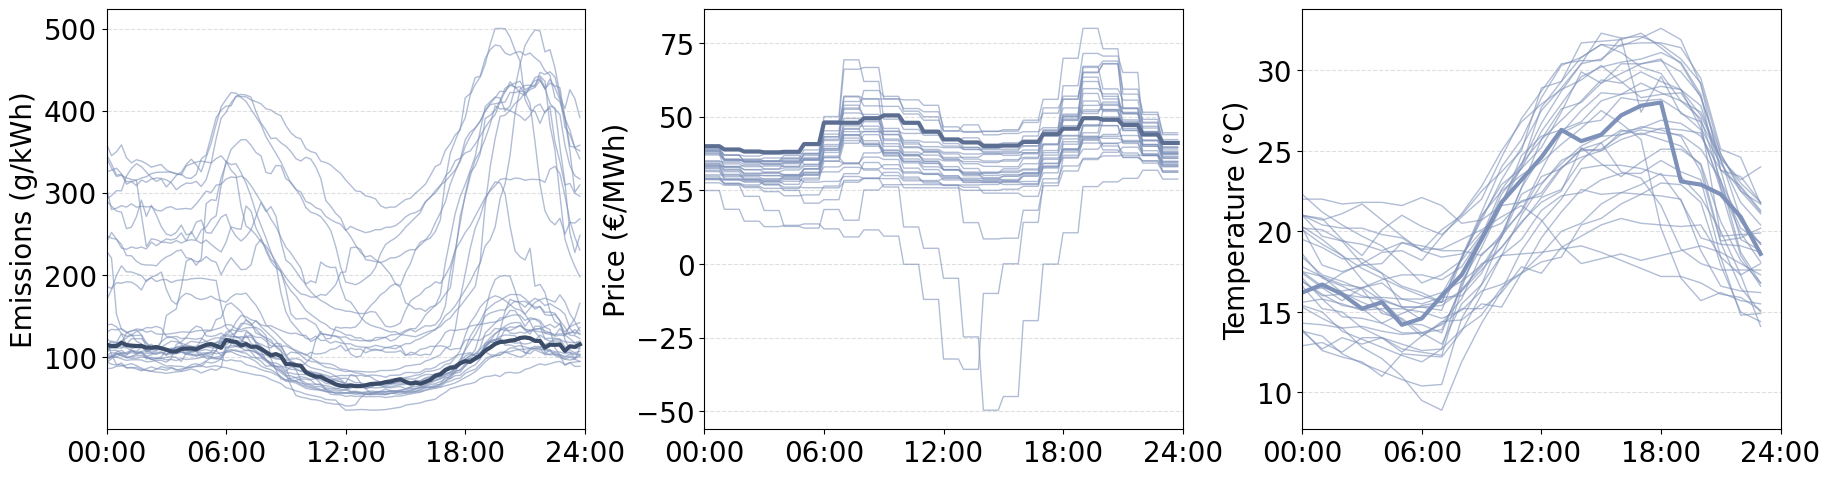

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Palette requested
PALETTE = ["#3b4c68", "#5c6e91", "#7e91b9", "#a0b5e2", "#c3d8ff", "#87929d", "#a3aab2", "#cfd2d5"]

def plot_day_with_month_bg_3col(
    emissions_path=r"dataset_clean\01exogenous_data\electricity_emissions_15min_transnetbw_2018_2024.csv",
    prices_path=r"dataset_clean\01exogenous_data\electricity_prices_15min_de_2018_2024.csv",
    weather_path=r"dataset_clean\01exogenous_data\weather_data_karlsruhe_hourly_2018_2024.csv",
    start_date="2019-08-02", tz="Europe/Berlin"
):
    # ---------- Load & time index ----------
    e = pd.read_csv(emissions_path, parse_dates=["utc_datetime"]).set_index("utc_datetime").sort_index()
    p = pd.read_csv(prices_path,    parse_dates=["utc_datetime"]).set_index("utc_datetime").sort_index()
    w = pd.read_csv(weather_path,   parse_dates=["utc_datetime"]).set_index("utc_datetime").sort_index()

    for df in (e, p, w):
        if df.index.tz is None:
            df.index = df.index.tz_localize("UTC")
        df.index = df.index.tz_convert(tz).tz_localize(None)

    e["emission_intensity_g_per_kwh"] = pd.to_numeric(e["emission_intensity_g_per_kwh"], errors="coerce")
    p["price_eur_per_mwh"]           = pd.to_numeric(p["price_eur_per_mwh"],           errors="coerce")
    w["temperature_air_mean_2m_°C"]  = pd.to_numeric(w["temperature_air_mean_2m_°C"],  errors="coerce")

    # ---------- Time windows ----------
    day_start = pd.Timestamp(start_date).normalize()
    day_end   = day_start + pd.Timedelta(days=1)

    month_start = day_start.replace(day=1)
    # first day of next month
    if month_start.month == 12:
        next_month_start = pd.Timestamp(year=month_start.year+1, month=1, day=1)
    else:
        next_month_start = pd.Timestamp(year=month_start.year, month=month_start.month+1, day=1)
    month_end = next_month_start

    # ---------- Helpers ----------
    def month_bg_and_day(df, value_col):
        m = df.loc[(df.index >= month_start) & (df.index < month_end), value_col].dropna()
        d = df.loc[(df.index >= day_start) & (df.index < day_end),     value_col].dropna()
        return m, d

    em_m, em_d = month_bg_and_day(e, "emission_intensity_g_per_kwh")
    pr_m, pr_d = month_bg_and_day(p, "price_eur_per_mwh")
    tp_m, tp_d = month_bg_and_day(w, "temperature_air_mean_2m_°C")

    # x = hours from midnight for plotting aligned daily profiles
    def to_hours_from_midnight(idx):
        return (idx - idx.normalize()).total_seconds() / 3600.0

    # ---------- Plot (3 columns, bigger fonts, grey monthly lines + highlighted day) ----------
    title_fs, label_fs, tick_fs = 20, 20, 20
    grey = "#7e91b9"

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

    panels = [
        ("Emissions (g/kWh)", em_m, em_d, PALETTE[0]),
        ("Price (€/MWh)",     pr_m, pr_d, PALETTE[1]),
        ("Temperature (°C)",  tp_m, tp_d, PALETTE[2]),
    ]

    for ax, (ylabel, month_series, day_series, color) in zip(axes, panels):
        # background: one light-grey line per day of the same month
        for date_val, sub in month_series.groupby(month_series.index.date):
            x_bg = to_hours_from_midnight(sub.index)
            ax.plot(x_bg, sub.values, color=grey, linewidth=1, alpha=0.6)

        # highlight chosen day
        x_day = to_hours_from_midnight(day_series.index)
        ax.plot(x_day, day_series.values, color=color, linewidth=3)

        ax.set_xlim(0, 24)
        ax.set_xticks([0, 6, 12, 18, 24])
        ax.set_xticklabels(["00:00","06:00","12:00","18:00","24:00"], fontsize=tick_fs)
        ax.tick_params(axis="y", labelsize=tick_fs)
        ax.set_ylabel(ylabel, fontsize=label_fs)
        ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    fig.subplots_adjust(left=0.06, right=0.99, top=0.88, bottom=0.18, wspace=0.25)
    out = f"exogenous_features.pdf"
    fig.savefig(out, dpi=150)
    plt.show()


# --- EXECUTION ---
plot_day_with_month_bg_3col(start_date="2019-08-02", tz="Europe/Berlin")
